In [9]:
import sys
sys.path.append('/home/ilia/pythia8313-install/lib/')

import pickle
import gzip
import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear, Dropout, BatchNorm1d, LeakyReLU
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GINConv, global_add_pool, SAGEConv, JumpingKnowledge, PNAConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from pythia8 import Pythia
import fastjet as fj
from safe_root import ROOT
import pandas as pd

In [2]:
# Загрузка 
with gzip.open('jet_dataset.pkl.gz', 'rb') as f:
    dataset = pickle.load(f)

In [3]:
class GINModel(torch.nn.Module):
    def __init__(self):
        super(GINModel, self).__init__()

        self.conv1 = GINConv(
            torch.nn.Sequential(
                Linear(4, 64),
                BatchNorm1d(64),
                LeakyReLU(0.01),
                Linear(64, 64),
                LeakyReLU(0.01)
            )
        )

        self.conv2 = GINConv(
            torch.nn.Sequential(
                Linear(64, 128),
                BatchNorm1d(128),
                LeakyReLU(0.01),
                Linear(128, 128),
                LeakyReLU(0.01)
            )
        )

        self.conv3 = GINConv(
            torch.nn.Sequential(
                Linear(128, 128),
                BatchNorm1d(128),
                LeakyReLU(0.01),
                Linear(128, 128),
                LeakyReLU(0.01)
            )
        )

        self.dropout = Dropout(0.4)
        self.fc1 = Linear(128, 64)
        self.fc2 = Linear(64, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.dropout(x)

        x = global_add_pool(x, batch)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)

        return self.fc2(x).squeeze(1)

In [5]:
# Разделение данных на обучающую и тестовую выборки
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Создаем DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Инициализация модели и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GINModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # L2 регуляризация
criterion = torch.nn.HuberLoss(delta=1.0)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',    # Минимизировать loss (по умолчанию)
    factor=0.5,    # Уменьшать lr в 2 раза
    patience=3,    # Ждать 3 эпохи без улучшений
    min_lr=1e-6    # Минимальный lr
)

Epoch: 01, LR: 5.00e-04, Train Loss: 0.4088, Test Loss: 0.3393
Epoch: 02, LR: 5.00e-04, Train Loss: 0.3689, Test Loss: 0.3334
Epoch: 03, LR: 5.00e-04, Train Loss: 0.3601, Test Loss: 0.3176
Epoch: 04, LR: 5.00e-04, Train Loss: 0.3569, Test Loss: 0.3172
Epoch: 05, LR: 5.00e-04, Train Loss: 0.3553, Test Loss: 0.3217
Epoch: 06, LR: 5.00e-04, Train Loss: 0.3538, Test Loss: 0.3258
Epoch: 07, LR: 5.00e-04, Train Loss: 0.3524, Test Loss: 0.3178
Epoch: 08, LR: 2.50e-04, Train Loss: 0.3516, Test Loss: 0.3227
Epoch: 09, LR: 2.50e-04, Train Loss: 0.3470, Test Loss: 0.3153
Epoch: 10, LR: 2.50e-04, Train Loss: 0.3452, Test Loss: 0.3180
Epoch: 11, LR: 2.50e-04, Train Loss: 0.3448, Test Loss: 0.3197
Epoch: 12, LR: 2.50e-04, Train Loss: 0.3446, Test Loss: 0.3233
Epoch: 13, LR: 1.25e-04, Train Loss: 0.3440, Test Loss: 0.3230
Epoch: 14, LR: 1.25e-04, Train Loss: 0.3412, Test Loss: 0.3136
Epoch: 15, LR: 1.25e-04, Train Loss: 0.3404, Test Loss: 0.3132
Epoch: 16, LR: 1.25e-04, Train Loss: 0.3399, Test Loss:

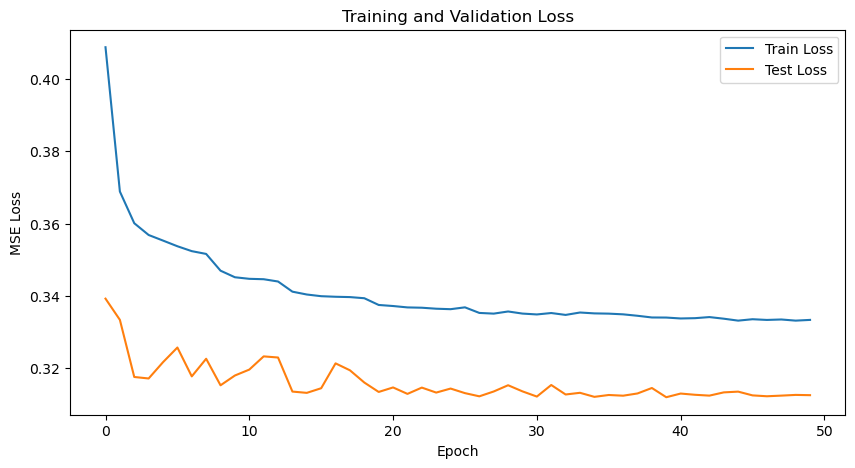

In [6]:
train_losses = []
test_losses = []
best_loss = float('inf')

for epoch in range(1, 51):
    # Фаза обучения
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.num_graphs
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Фаза валидации
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            test_loss += criterion(out, data.y).item() * data.num_graphs
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    # Обновление scheduler и сохранение лучшей модели
    scheduler.step(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Логирование
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch:02d}, LR: {current_lr:.2e}, '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('loss_curve.png')
plt.show()

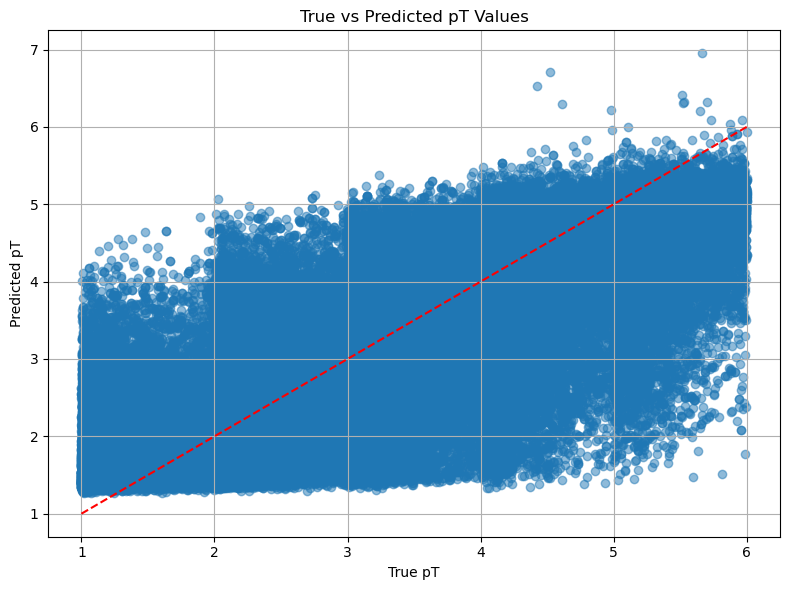


Final Metrics: MAE: 0.6578, R2 Score: 0.6859


In [7]:
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred = model(data)
        predictions.append(pred.cpu())
        targets.append(data.y.cpu())

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(targets, predictions, alpha=0.5)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
plt.xlabel('True pT')
plt.ylabel('Predicted pT')
plt.title('True vs Predicted pT Values')
plt.grid(True)
plt.tight_layout()
plt.show()

mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)
print(f"\nFinal Metrics: MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}")

In [10]:
mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)
print(f"\nFinal Metrics: MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}")


Final Metrics: MAE: 0.6578, MSE: 0.7201, R2 Score: 0.6859
